# Evaluation

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt, dates, colors, patches
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from tqdm import tqdm

import process_NEMO_obs_matching as tools

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

***

## Plotting functions

In [118]:
def calc_stats(x, y):
    """
    """
    
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['MAE'] = np.mean(abs(y)) - np.mean(abs(x))
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, category, x, y, lims, units, cmax=500, bins=80):
    """
    """
    
    stats = calc_stats(x, y)
    if category == 'drifters':
        statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nMAE = {stats['MAE']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    else:
        statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    _, _, _, c = ax.hist2d(x, y, bins=bins, range=(lims, lims), norm=colors.LogNorm(vmin=1, vmax=cmax))
    ax.plot(lims, lims, 'r--')
    ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c


def plot_comparisons(data, category, cmax=100, bbox=[None, None, -128, None, None, 5], wind_threshold=0):
    """
    """
    
    # Parse category variables
    names = ['longitude', 'latitude']
    bounds = [bbox[:2], bbox[2:4]]
    if category == 'drifters':
        variables, units, lims = ['u', 'v'], ['m/s', 'm/s'], [(-2, 2), (-2, 2)]
    else:
        variables, units, lims = ['T', 'S'], ['$^{\circ}$C', 'g/kg'], [(8, 22), (5, 32)]
        names.append('depth')
        bounds.append(bbox[4:])
        
    # Make figure
    fig, axs = plt.subplots(2, 4, figsize=(17, 8))

    # Loop through cases and variables
    for col, runID in zip(axs.T, ['nowaves', 'base', 'charnock', 'rascle']):
        col[0].set_title(runID)
        for ax, var, lim, unit in zip(col, variables, lims, units):
            
            # Define x and y
            coords = [data[category][runID][name].values for name in names]
            x, y = [data[category][runID][var + key].values for key in ('_obs', '_nemo')]
            index = tools.get_bbox_index(coords, bounds)
            index = np.logical_and(index, data[category][runID]['wspd'] > wind_threshold)
            x, y = x[index], y[index]
            
            # Plot data
            c = plot_panel(ax, category, x, y, lim, unit, cmax=cmax, bins=100)

            # Formatting
            ax.set_xlim(lim)
            ax.set_ylim(lim)
            ax.set_xlabel(f'observations [{unit}]')
            if runID == 'nowaves':
                ax.set_ylabel(f'NEMO [{unit}]')
                ax.text(0.02, 0.95, var, transform=ax.transAxes)
            else:
                ax.yaxis.set_ticklabels('')
    
    return fig, ax

***

## Load data

In [ ]:
# Load HRDPS
HRDPS_path = '/project/def-allen/SalishSea/forcing/atmospheric/GEM2.5/operational/'
startdate = datetime(2016, 4, 1)
ts_wind, u_wind, v_wind = [], [], []
for day in tqdm(range(548)):
    date = startdate + timedelta(days=day)
    fn = date.strftime('ops_y%Ym%md%d.nc')
    ds = xr.open_dataset(HRDPS_path + fn)
    ts_wind.append(ds.time_counter.values.astype('datetime64[s]').astype(datetime))
    u, v = [ds[var].isel(y=149, x=141).values for var in ['u_wind', 'v_wind']]
    u_wind.append(u)
    v_wind.append(v)
ts_wind = np.array([t.timestamp() for t in np.hstack(ts_wind)])
wspd = np.sqrt(np.hstack(u_wind)**2 + np.hstack(v_wind)**2)

In [86]:
# Paths
path = '/scratch/bmoorema/evaluation'

# Case parameters
runIDs = ['nowaves', 'base', 'charnock', 'rascle']
categories = ['drifters', 'PSF', 'DFO']
datestrs = ['20160401_20160930', '20161001_20170331', '20170401_20170930']

# Load data
data = {}
for category in categories:
    data[category] = {}
    if category == 'drifters':
        variables = ['u_obs', 'v_obs', 'u_nemo', 'v_nemo']
    else:
        variables = ['T_obs', 'S_obs', 'T_nemo', 'S_nemo']
    for runID in runIDs:
        prefix = f'{path}/{category}/SSC{category}_{runID}'
        df = pd.concat([pd.read_csv(f'{prefix}_{datestr}.csv', parse_dates=[0]) for datestr in datestrs], ignore_index=True)
        index = np.logical_and.reduce([np.isfinite(df[var]) for var in variables])
        index = np.logical_and(index, ~df['time'].isnull())
        df = df[index]
        if runID == 'nowaves':
            ts = np.array([t.to_pydatetime().timestamp() for t in df['time']])
            wspd_interp = np.interp(ts, ts_wind, wspd)
        df['wspd'] = wspd_interp
        data[category][runID] = df

***

## Plots

### All points

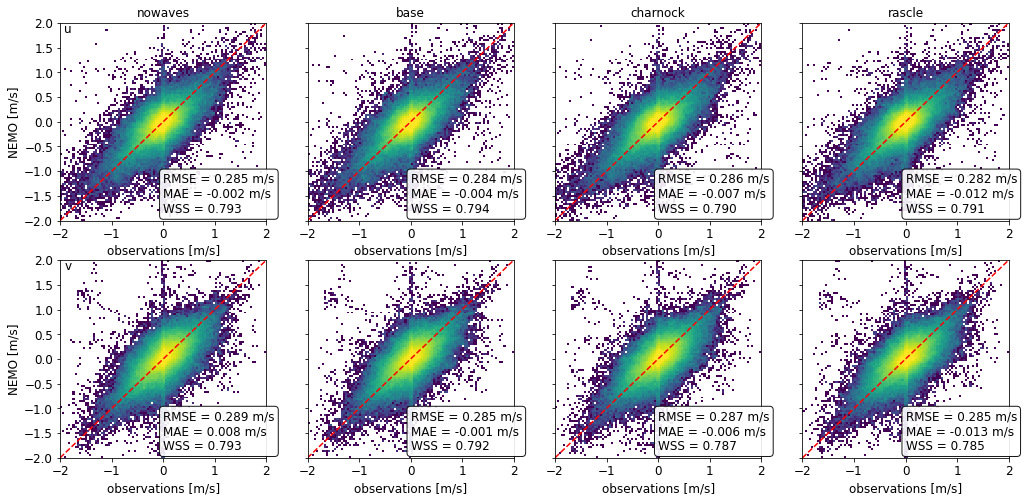

In [97]:
fig, ax = plot_comparisons(data, 'drifters', cmax=1000)

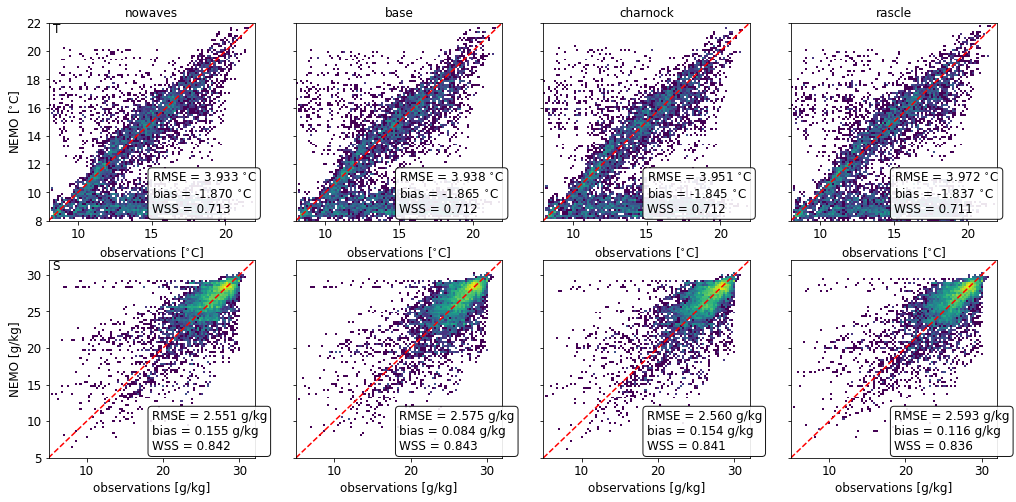

In [121]:
fig, ax = plot_comparisons(data, 'PSF', cmax=100)

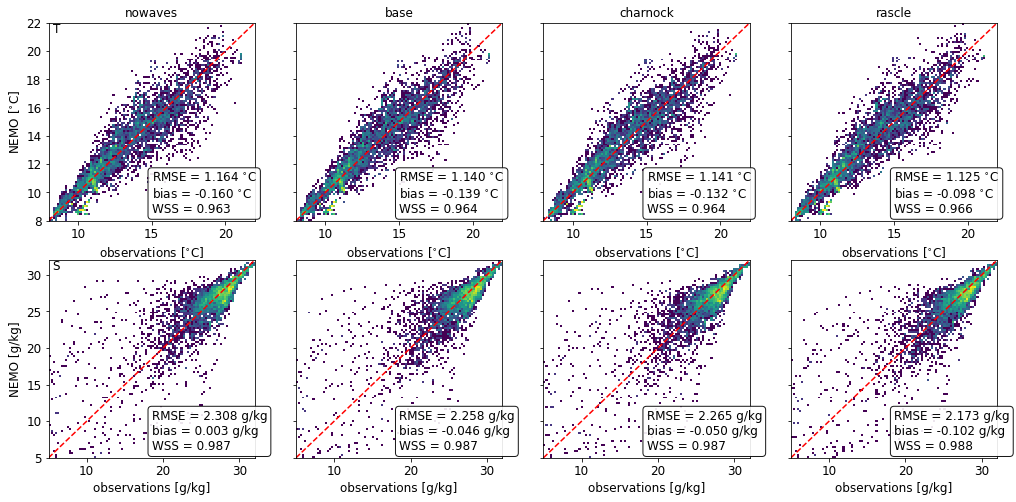

In [122]:
fig, ax = plot_comparisons(data, 'DFO', cmax=100)

***

### Wind speed > 10 m/s

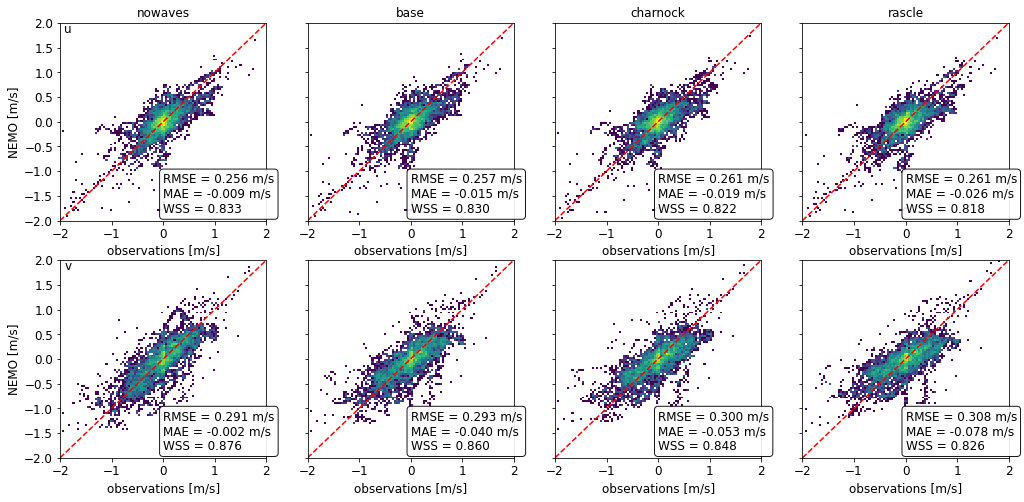

In [104]:
fig, ax = plot_comparisons(data, 'drifters', cmax=100, wind_threshold=10)

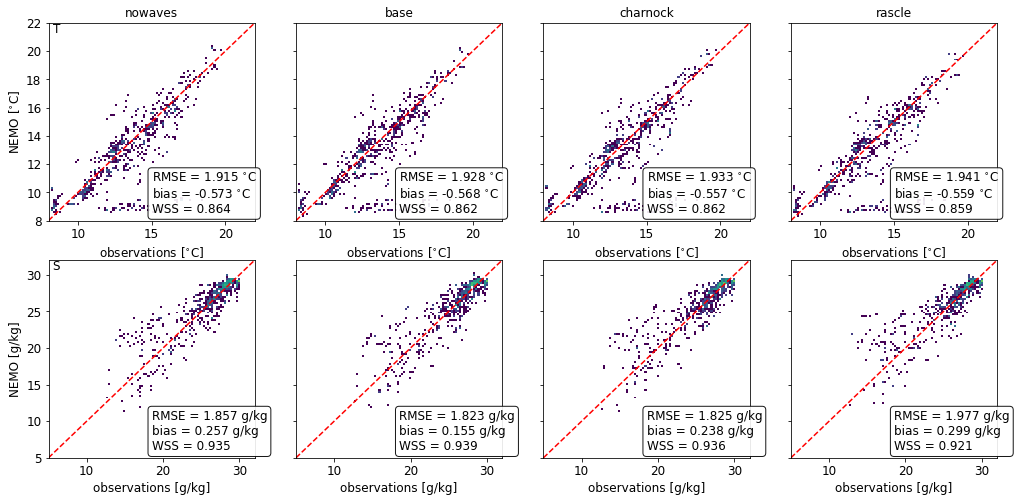

In [123]:
fig, ax = plot_comparisons(data, 'PSF', cmax=50, wind_threshold=8)

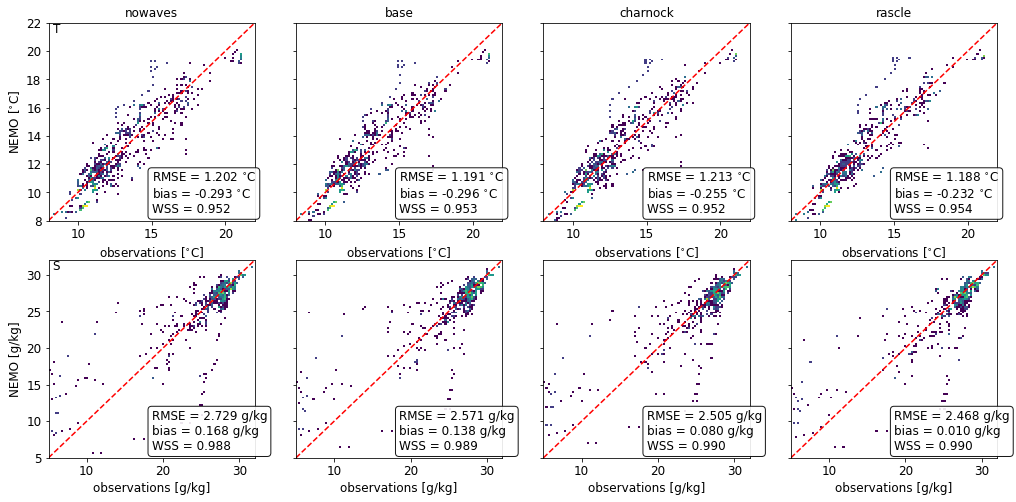

In [124]:
fig, ax = plot_comparisons(data, 'DFO', cmax=50, wind_threshold=8)